In [15]:
import pandas as pd
import re
import numpy as np
import ast
import datetime
import uuid

In [16]:
df=pd.read_csv("anuncios_unificados.csv")

In [17]:
marcas = [
    'ALFA ROMEO', 'ASTON MARTIN', 'AUDI', 'BENTLEY', 'BMW', 'BYD', 'CHEVROLET', 'CITROEN', 'CUPRA',
    'DACIA', 'DFSK', 'DS', 'FIAT', 'FORD', 'HONDA', 'HYUNDAI', 'INFINITI', 'ISUZU', 'JAGUAR', 'JEEP',
    'KIA', 'LADA', 'LAMBORGHINI', 'LANCIA', 'LAND-ROVER', 'LEXUS', 'MASERATI', 'MAZDA', 'MERCEDES-BENZ',
    'MG', 'MINI', 'MITSUBISHI', 'NISSAN', 'OPEL', 'PEUGEOT', 'POLARIS', 'PORSCHE', 'RENAULT', 'ROLLS-ROYCE',
    'ROVER', 'SAAB', 'SEAT', 'SKODA', 'SMART', 'SSANGYONG', 'SUBARU', 'SUZUKI', 'TESLA', 'TOYOTA',
    'VOLKSWAGEN', 'VOLVO', 'HUMMER', 'DODGE', 'KGM / SSANGYONG', 'LYNK & CO' , "EVO" , "McLAREN" , "FERRARI" ,
    "BESTUNE" , "ABARTH" , "RAM" , "JAECOO" , "CADILLAC" , "OMODA" , "LINCOLN" , "DR" , "LOTUS" , "GMC" ,
    "POLESTAR" , "MAXUS" , "CHRYSLER" , "HURTAN" , "XEV" , "GALLOPER" , "EBRO" , "GENESIS"
]

marcas_mayus = [m.upper() for m in marcas]

def extraer_marca_modelo(titulo):
    for marca in marcas_mayus:
        if titulo.upper().startswith(marca):
            marca_real = marcas[marcas_mayus.index(marca)]  # Recupera nombre con mayúsculas correctas
            modelo = titulo[len(marca):].strip()
            # Elimina repeticiones como "Genesis Genesis"
            if modelo.upper().startswith(marca):
                modelo = modelo[len(marca):].strip()
            return pd.Series([marca_real, modelo])
    return pd.Series([None, None])

df[['marca', 'modelo']] = df['titulo'].apply(extraer_marca_modelo)

df.drop(columns=['titulo', 'url',], inplace=True)

columnas = ['marca', 'modelo'] + [col for col in df.columns if col not in ['marca', 'modelo']]
df = df[columnas]

In [18]:
def limpiar_financiacion(df):
    df['financiacion_disponible'] = df['precio_financiado'].notna().astype(int)
    df.drop(columns=['precio_financiado'], inplace=True)
    return df

df = limpiar_financiacion(df)


In [19]:
def limpiar_precio_y_descuento(df):
    df = df.copy()
    df['precio_contado'] = df['precio_contado'].str.replace('Al contado', '', regex=False).str.strip()
    df = df[~df['precio_contado'].isin(['Consultar-100%', 'Consultar'])]

    df['descuento'] = df['precio_contado'].str.extract(r'€\s*(.+)$', expand=False).fillna('')
    df['precio_contado'] = df['precio_contado'].str.replace(r'€\s*.+$', '€', regex=True).str.strip()
    df['descuento'] = df['descuento'].replace('', '0%')
    df['descuento_num'] = df['descuento'].str.replace('%', '', regex=False).astype(float) / 100

    df['precio_contado'] = df['precio_contado'].str.replace('€', '', regex=False)
    df['precio_contado'] = df['precio_contado'].str.replace('.', '', regex=False).str.strip()
    df['precio_contado'] = pd.to_numeric(df['precio_contado'], errors='coerce')

    df['precio'] = df['precio_contado'] * (1 + df['descuento_num'])
    df = df.rename(columns={'precio': 'precio_final'})

    df = df.drop(columns=['descuento'])
    df = df.rename(columns={'descuento_num': 'descuento'})
    df['precio_contado'] = df['precio_contado'].astype(float)

    return df

df = limpiar_precio_y_descuento(df)


In [20]:
def limpiar_tags(df):
    df = df.copy()

    df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    df['ubicacion'] = df['tags'].apply(lambda x: x[-1] if isinstance(x, list) and len(x) > 0 else None)
    df['kilometraje'] = df['tags'].apply(lambda x: x[-2] if isinstance(x, list) and len(x) > 1 else None)

    df['kilometraje'] = (
        df['kilometraje']
        .str.replace('.', '', regex=False)
        .str.replace(' km', '', regex=False)
        .astype(float)
    )

    def extraer_combustible(tag_list):
        if isinstance(tag_list, list) and len(tag_list) >= 3:
            posible_combustible = tag_list[-3]
            if not posible_combustible.isdigit() or len(posible_combustible) != 4:
                return posible_combustible
        return None

    df['combustible'] = df['tags'].apply(extraer_combustible)
    df = pd.get_dummies(df, columns=['combustible'], prefix='combustible', dummy_na=True)

    df['es_km0'] = df['tags'].apply(lambda x: 'Km0' in x if isinstance(x, list) else False)
    df['es_demo'] = df['tags'].apply(lambda x: 'Demo' in x if isinstance(x, list) else False)

    df.drop(columns=['tags'], inplace=True)

    return df

df = limpiar_tags(df)



In [21]:
def limpiar_detalles_ficha(df):
    def extraer_detalles(detalles):
        transmision = garantia = tipo_carroceria = asientos = potencia = puertas = mes = año = np.nan
        if isinstance(detalles, list):
            for item in detalles:
                if isinstance(item, str):
                    if 'Automático' in item or 'Manual' in item:
                        transmision = item
                    elif 'Garantía:' in item:
                        garantia = item.replace('Garantía:', '').strip()
                    elif item in ['Berlina', 'Todo Terreno', 'Stationwagon', 'Monovolumen', 'SUV', 'Coupé',
                                  'Deportivo', 'Familiar', 'Pickup', '4x4', 'Pequeño', 'Descapotable', 'Sedán', 'Hatchback']:
                        tipo_carroceria = item
                    elif 'asientos' in item.lower():
                        asientos = int(re.search(r'\d+', item).group()) if re.search(r'\d+', item) else np.nan
                    elif 'cv' in item.lower():
                        potencia = int(re.search(r'\d+', item).group()) if re.search(r'\d+', item) else np.nan
                    elif 'Puertas' in item:
                        puertas = int(re.search(r'\d+', item).group()) if re.search(r'\d+', item) else np.nan
                    elif 'Matriculado:' in item:
                        fecha = item.replace('Matriculado:', '').strip()
                        if '/' in fecha:
                            mes, año = fecha.split('/')
                            mes = int(mes)
                            año = int(año)
        return pd.Series([transmision, garantia, tipo_carroceria, asientos, potencia, puertas, mes, año])

    df['detalles_ficha'] = df['detalles_ficha'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    columnas_nuevas = ['transmision', 'garantia', 'tipo_carroceria', 'asientos', 'potencia', 'puertas',
                       'mes_matriculacion2', 'año_matriculacion2']
    df[columnas_nuevas] = df['detalles_ficha'].apply(extraer_detalles)

    df.drop(columns=['detalles_ficha'], inplace=True, errors='ignore')

    return df

df = limpiar_detalles_ficha(df)


In [22]:
def limpiar_columna_plazo(col):
    col = col.fillna('0').replace({'No': '0'})
    moda = col[col.str.contains('meses', na=False)].mode()[0]
    col = col.replace({'Sí': moda})
    col = col.str.replace('meses', '', regex=False).str.strip().astype(int)
    return col

df['garantia_limpia'] = limpiar_columna_plazo(df['garantia'])

df.drop(columns=['garantia'], inplace=True)

In [23]:
def limpieza_final(df):
    df['transmision'] = df['transmision'].fillna('Automático')
    df['transmision_cod'] = df['transmision'].map({'Automático': 0, 'Manual': 1, 'Desconocido': 2})

    df['tipo_carroceria'] = df['tipo_carroceria'].fillna('Desconocido')
    df['asientos'] = df['asientos'].fillna(0)
    df['potencia'] = df['potencia'].fillna(0)

    mediana_año = df['año_matriculacion2'].median()
    df['año_matriculacion2'] = df['año_matriculacion2'].fillna(mediana_año)

    mediana_mes = df['mes_matriculacion2'].median()
    df['mes_matriculacion2'] = df['mes_matriculacion2'].fillna(mediana_mes)

    moda_puertas = df['puertas'].mode()[0]
    df['puertas'] = df['puertas'].fillna(moda_puertas)
    
    return df

df = limpieza_final(df)


In [24]:
df.to_csv('datos_limpios.csv', index=False)

In [25]:

def agregar_id_y_timestamp(df):
    df['id_registro'] = [str(uuid.uuid4()) for _ in range(len(df))]
    
    df['timestamp_extraccion'] = datetime.datetime.now()
    
    return df

df = agregar_id_y_timestamp(df)



In [26]:
df

,marca,modelo,precio_contado,financiacion_disponible,descuento,precio_final,ubicacion,kilometraje,combustible_Diésel,combustible_Eléctrico,...,tipo_carroceria,asientos,potencia,puertas,mes_matriculacion2,año_matriculacion2,garantia_limpia,transmision_cod,id_registro,timestamp_extraccion
0,MERCEDES-BENZ,Clase A 200 Sedán,40900.0,0,0.0,40900.0,Córdoba,10.0,False,False,...,Desconocido,5.0,163.0,4.0,1.0,2025.0,24,0,733b1e0c-0b40-4843-b31a-e65bf61cbc59,2025-06-08 15:27:34.610393
1,BMW,X1 iX1 eDrive20,42900.0,1,0.0,42900.0,León,5145.0,False,True,...,Todo Terreno,5.0,204.0,5.0,9.0,2024.0,24,0,a3bda56a-d7ef-45db-84e0-512c80740f14,2025-06-08 15:27:34.610393
2,BMW,X5 xDrive 30dA xLine,78900.0,1,0.0,78900.0,León,12356.0,True,False,...,Todo Terreno,5.0,298.0,5.0,5.0,2024.0,24,0,a10301e5-9405-4783-a2e6-06c0ed740d6b,2025-06-08 15:27:34.610393
3,CITROEN,C3 PureTech 60KW (83CV) Max,14490.0,1,0.0,14490.0,Zaragoza,15730.0,False,False,...,Desconocido,0.0,83.0,5.0,3.0,2024.0,24,1,3edebcff-35fd-4186-a0b5-ca1c85893e4f,2025-06-08 15:27:34.610393
4,MERCEDES-BENZ,Citan Tourer 110CDI Base,22293.0,1,0.0,22293.0,Barcelona,43191.0,True,False,...,Monovolumen,5.0,95.0,5.0,5.0,2023.0,36,1,2d5d9f4f-0515-4513-9631-eae2a5e37372,2025-06-08 15:27:34.610393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9324,HYUNDAI,Tucson 1.7CRDI BD Tecno Sky DT 4x2 141,17990.0,0,0.0,17990.0,Salamanca,124000.0,True,False,...,Todo Terreno,5.0,141.0,5.0,2.0,2017.0,12,0,cf881266-87f1-4469-9493-15056026c5c4,2025-06-08 15:27:34.610393
9325,PEUGEOT,3008 1.6 BlueHDi Crossway EAT6 120,13500.0,0,0.0,13500.0,Alicante,147000.0,True,False,...,Monovolumen,5.0,120.0,5.0,3.0,2016.0,12,0,fa3fca45-d800-444b-8df1-172872463755,2025-06-08 15:27:34.610393
9326,RENAULT,Rafale 1.2 E-Tech Híbrido Esprit Alpine 147kW,43990.0,1,0.0,43990.0,Cantabria,17285.0,False,False,...,Todo Terreno,5.0,200.0,5.0,5.0,2024.0,12,0,c53cfaa6-ef9f-44da-b564-066f28cd0ff8,2025-06-08 15:27:34.610393
9327,MERCEDES-BENZ,Clase B 180CDI BE,11600.0,1,0.0,11600.0,Tarragona,148707.0,True,False,...,Monovolumen,5.0,109.0,5.0,6.0,2013.0,12,1,a76f412a-0255-45d0-b118-8a75348067a1,2025-06-08 15:27:34.610393


Resumen estadístico de variables numéricas:
       precio_contado  financiacion_disponible    descuento  precio_final  \
count    9.249000e+03              9249.000000  9249.000000  9.249000e+03   
mean     4.657236e+04                 0.688074    -0.002705  4.650185e+04   
min      1.000000e+02                 0.000000    -0.260000  1.000000e+02   
25%      1.599000e+04                 0.000000     0.000000  1.599000e+04   
50%      2.290000e+04                 1.000000     0.000000  2.289900e+04   
75%      3.690000e+04                 1.000000     0.000000  3.690000e+04   
max      5.354900e+06                 1.000000     0.000000  5.354900e+06   
std      1.020139e+05                 0.463305     0.013074  1.020101e+05   

        kilometraje     asientos     potencia      puertas  \
count  9.249000e+03  9249.000000  9249.000000  9249.000000   
mean   7.309800e+04     3.882798   197.296789     4.630987   
min    0.000000e+00     0.000000     0.000000     2.000000   
25%    2.15540

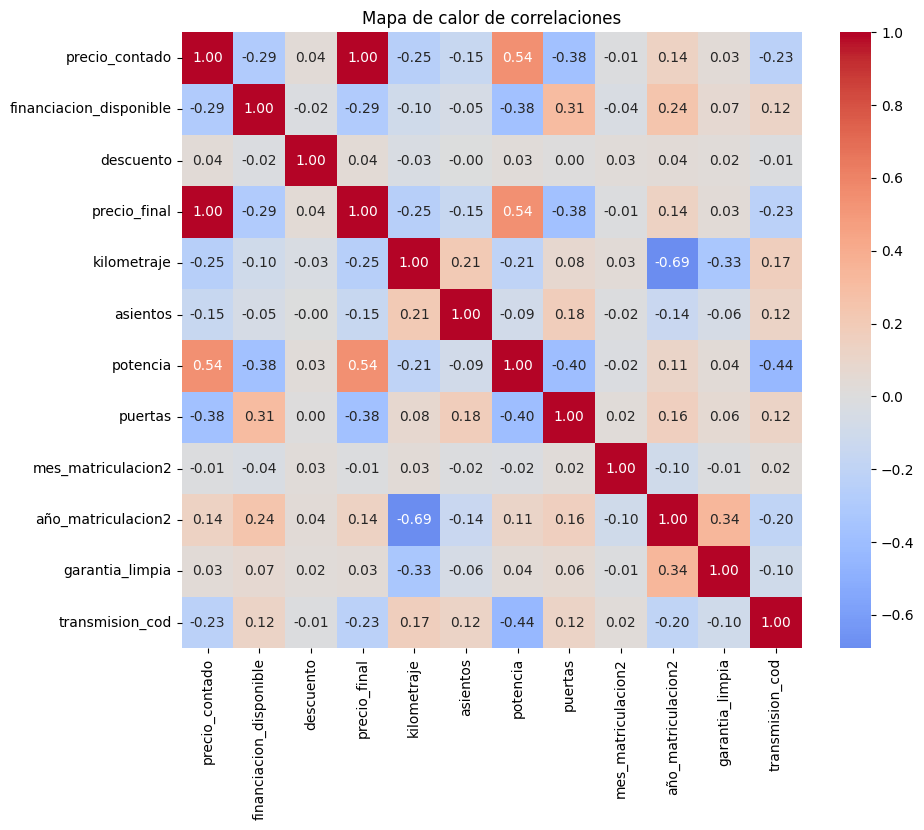

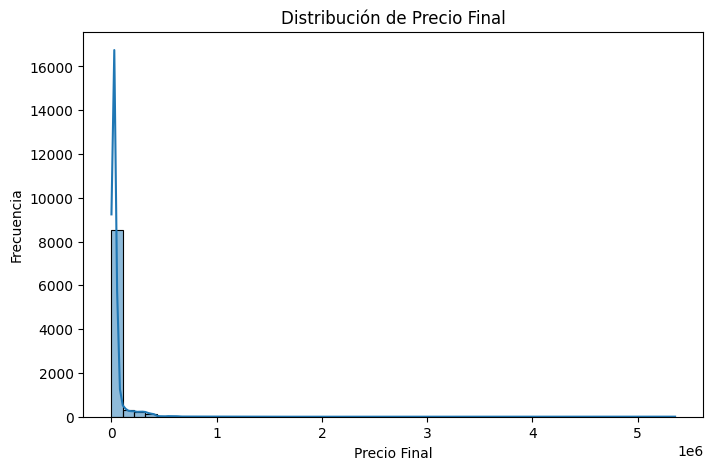

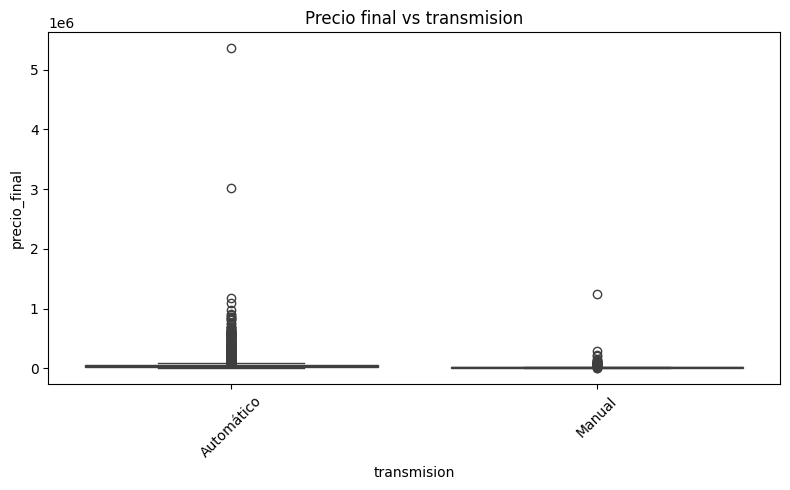

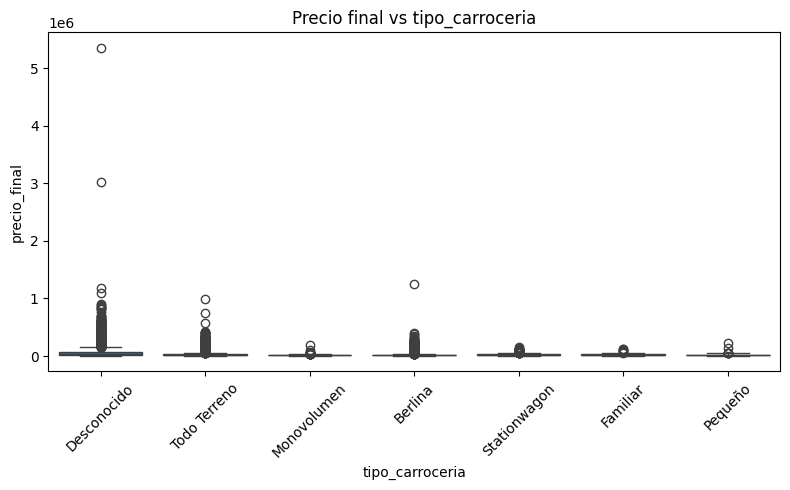

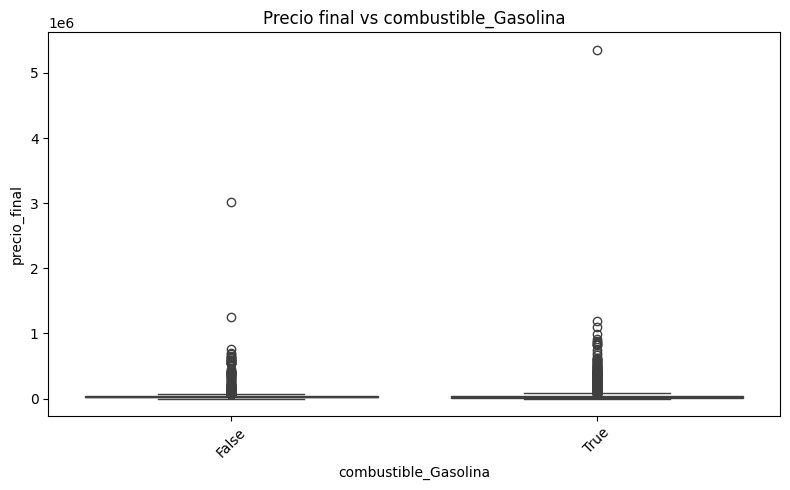

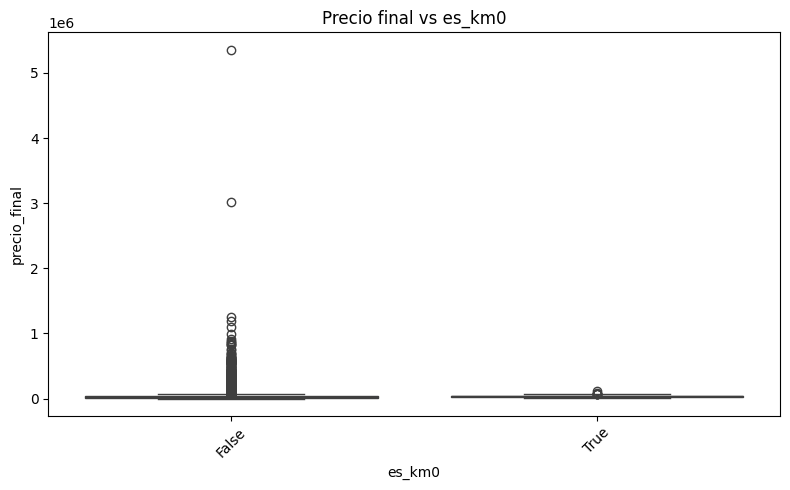

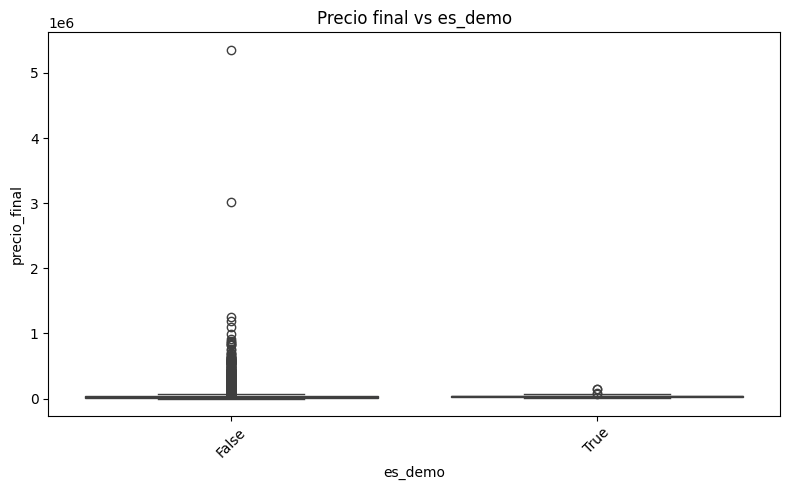

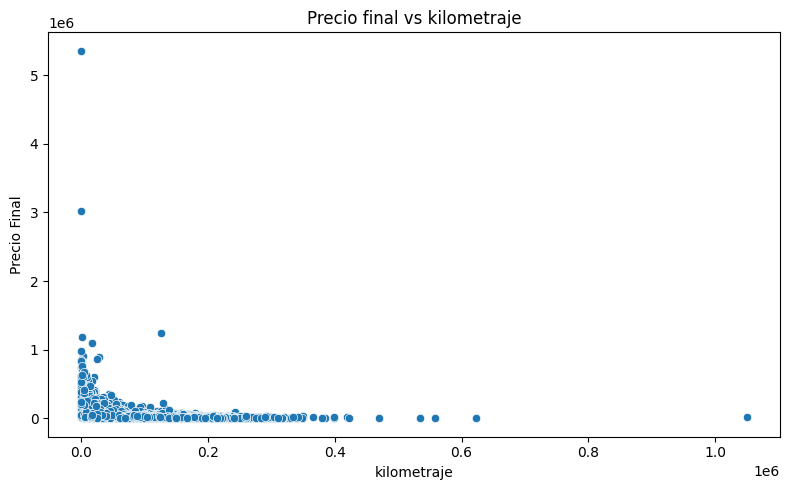

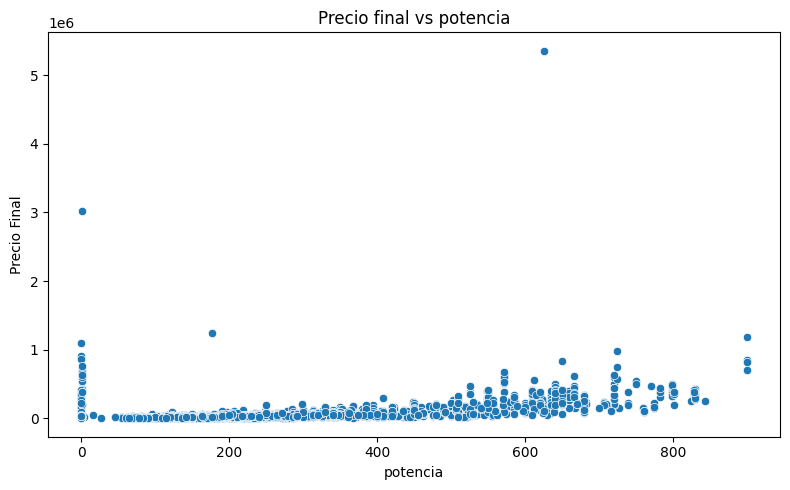

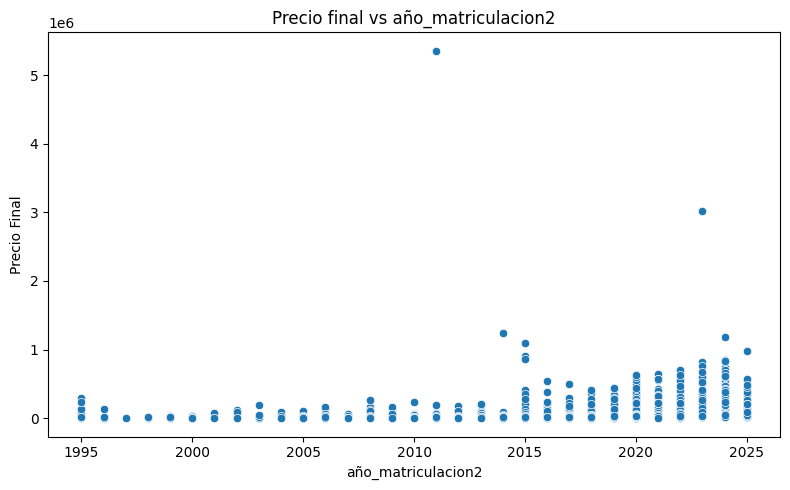

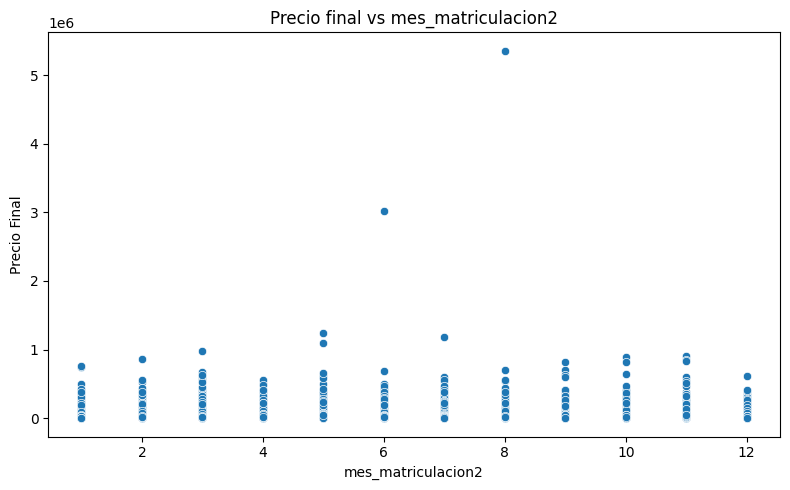

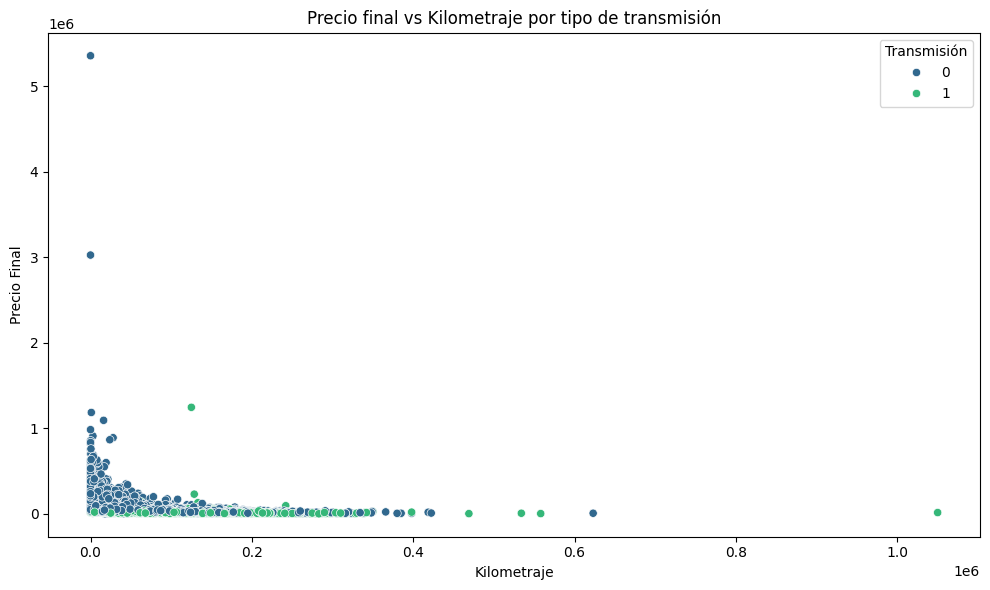

In [ ]:
# 1. Estadísticas descriptivas del target y variables numéricas
print("Resumen estadístico de variables numéricas:")
print(df.describe())

# 2. Correlación numérica con el target 'precio_final'
numeric_df = df.select_dtypes(include='number')  # Solo variables numéricas
corr = numeric_df.corr()
print("\nCorrelaciones con 'precio_final':")
print(corr['precio_final'].sort_values(ascending=False))

# 3. Heatmap de correlaciones para variables numéricas
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Mapa de calor de correlaciones')
plt.show()

# 4. Distribución del target 'precio_final'
plt.figure(figsize=(8, 5))
sns.histplot(df['precio_final'], bins=50, kde=True)
plt.title('Distribución de Precio Final')
plt.xlabel('Precio Final')
plt.ylabel('Frecuencia')
plt.show()

# 5. Boxplots para variables categóricas relevantes vs precio_final
categoricas = ['transmision', 'tipo_carroceria', 'combustible_Gasolina', 'es_km0', 'es_demo']  # Ajusta si es necesario

for cat in categoricas:
    if cat in df.columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=df[cat], y=df['precio_final'])
        plt.title(f'Precio final vs {cat}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# 6. Scatter plot de variables numéricas importantes vs precio_final
numericas = ['kilometraje', 'potencia', 'año_matriculacion2', 'mes_matriculacion2']

for num in numericas:
    if num in df.columns:
        plt.figure(figsize=(8, 5))
        sns.scatterplot(x=df[num], y=df['precio_final'])
        plt.title(f'Precio final vs {num}')
        plt.xlabel(num)
        plt.ylabel('Precio Final')
        plt.tight_layout()
        plt.show()

# 7. Scatter plot Precio final vs Kilometraje coloreado por tipo de transmisión (si existe)
plt.figure(figsize=(10, 6))
if 'transmision_cod' in df.columns:
    sns.scatterplot(data=df, x='kilometraje', y='precio_final', hue='transmision_cod', palette='viridis')
else:
    sns.scatterplot(data=df, x='kilometraje', y='precio_final')

plt.title('Precio final vs Kilometraje por tipo de transmisión')
plt.xlabel('Kilometraje')
plt.ylabel('Precio Final')
plt.legend(title='Transmisión', loc='best')
plt.tight_layout()
plt.show()




In [ ]:
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Dashboard de Análisis de Vehículos"),

    html.Div([
        html.Label("Filtro por Tipo de Transmisión"),
        dcc.Dropdown(
            id='transmision_filter',
            options=[{'label': t, 'value': t} for t in df['transmision'].unique()] + [{'label': 'Todos', 'value': 'Todos'}],
            value='Todos',
            clearable=False
        )
    ], style={'width': '25%', 'display': 'inline-block'}),

    html.Div([
        html.Label("Filtro por Tipo de Carrocería"),
        dcc.Dropdown(
            id='carroceria_filter',
            options=[{'label': c, 'value': c} for c in df['tipo_carroceria'].unique()] + [{'label': 'Todos', 'value': 'Todos'}],
            value='Todos',
            clearable=False
        )
    ], style={'width': '25%', 'display': 'inline-block', 'marginLeft': '20px'}),

    dcc.Graph(id='scatter_km_precio'),
    dcc.Graph(id='boxplot_precio_transmision'),
])

@app.callback(
    [Output('scatter_km_precio', 'figure'),
     Output('boxplot_precio_transmision', 'figure')],
    [Input('transmision_filter', 'value'),
     Input('carroceria_filter', 'value')]
)
def update_graphs(transmision_sel, carroceria_sel):
    dff = df.copy()

    if transmision_sel != 'Todos':
        dff = dff[dff['transmision'] == transmision_sel]

    if carroceria_sel != 'Todos':
        dff = dff[dff['tipo_carroceria'] == carroceria_sel]

    fig_scatter = px.scatter(
        dff,
        x='kilometraje',
        y='precio_final',
        color='tipo_carroceria',
        title='Precio Final vs Kilometraje',
        labels={'kilometraje': 'Kilometraje', 'precio_final': 'Precio Final'}
    )

    fig_box = px.box(
        dff,
        x='transmision',
        y='precio_final',
        title='Distribución de Precio Final por Tipo de Transmisión',
        labels={'transmision': 'Transmisión', 'precio_final': 'Precio Final'}
    )

    return fig_scatter, fig_box

if __name__ == '__main__':
    app.run(debug=True, port=8050)


